# 🧠 Análisis de la Readmisión a la UCI en Pacientes con Hemorragia Intracerebral (MIMIC-IV)

## 1. 🔧 Configuración Inicial

In [2]:
from google.cloud import bigquery
from google.oauth2 import service_account

# Path to your service account key file
SERVICE_ACCOUNT_FILE = "mimic-sergi.json"
PROJECT_ID = "ogi-uci-i61"

# Create credentials and client
credentials = service_account.Credentials.from_service_account_file(
    SERVICE_ACCOUNT_FILE)

client = bigquery.Client(credentials=credentials, project=PROJECT_ID)

# Example query
query = "SELECT 'Hello, World!' AS greeting"
query_job = client.query(query)

# Fetch results
results = query_job.result()

for row in results:
    print(row.greeting)

Hello, World!


## 2. 📦 Extracción de Datos

In [3]:
# SQL query to extract data on ICU patients with Intracerebral Hemorrhage (ICH)
query = """
WITH ich_admissions AS (
  SELECT DISTINCT hadm_id
  FROM `ogi-uci-i61.mimiciv_hosp.diagnoses_icd` i
  JOIN `ogi-uci-i61.mimiciv_hosp.d_icd_diagnoses` d
    ON i.icd_code = d.icd_code AND i.icd_version = d.icd_version
  WHERE LOWER(d.long_title) LIKE '%intracerebral hemorrhage%'
),

chartevents_avg AS (
  SELECT
    c.stay_id,
    AVG(CASE WHEN itemid = 220045 AND valuenum > 0 THEN valuenum END) AS heart_rate_avg,
    AVG(CASE WHEN itemid = 220052 AND valuenum BETWEEN 30 AND 200 THEN valuenum END) AS mbp_avg,
    AVG(CASE WHEN itemid = 220210 AND valuenum BETWEEN 5 AND 60 THEN valuenum END) AS resp_rate_avg,
    AVG(CASE WHEN itemid = 220277 AND valuenum BETWEEN 70 AND 100 THEN valuenum END) AS spo2_avg,
  FROM `ogi-uci-i61.mimiciv_icu.chartevents` c
  JOIN `ogi-uci-i61.mimiciv_icu.icustays` i ON c.stay_id = i.stay_id
  WHERE c.itemid IN (220045, 220052, 220210, 220277, 223762)
    AND c.valuenum IS NOT NULL
    AND c.charttime BETWEEN i.intime AND i.outtime
  GROUP BY c.stay_id
),

cbc_labs AS (
  SELECT
    subject_id,
    hadm_id,
    AVG(wbc) AS wbc_avg,
    MIN(hemoglobin) AS hgb_min
  FROM `ogi-uci-i61.mimiciv_derived.complete_blood_count`
  GROUP BY subject_id, hadm_id
),

chem_labs AS (
  SELECT
    subject_id,
    hadm_id,
    MAX(creatinine) AS creatinine_max,
    AVG(glucose) AS glucose_avg
  FROM `ogi-uci-i61.mimiciv_derived.chemistry`
  GROUP BY subject_id, hadm_id
),

coag_labs AS (
  SELECT
    subject_id,
    hadm_id,
    MAX(inr) AS inr_max,
    MAX(pt) AS pt_max
  FROM `ogi-uci-i61.mimiciv_derived.coagulation`
  GROUP BY subject_id, hadm_id
)

SELECT
  a.subject_id,
  a.hadm_id,
  a.stay_id,
  p.gender,
  p.anchor_age AS age,
  a.intime,
  a.outtime,
  a.first_careunit,
  TIMESTAMP_DIFF(a.outtime, a.intime, HOUR) AS icu_los_hours,
  TIMESTAMP_DIFF(adm.dischtime, adm.admittime, HOUR) AS hosp_los_hours,
  adm.discharge_location,
  adm.hospital_expire_flag,

  STRING_AGG(CASE WHEN LOWER(d.long_title) LIKE '%intracerebral hemorrhage%' THEN i.icd_code END, '; ') AS ich_icd_codes,
  STRING_AGG(CASE
               WHEN LOWER(d.long_title) LIKE '%intracerebral hemorrhage%' THEN CONCAT(i.icd_code, ': ', d.long_title)
               ELSE i.icd_code
             END, '; ') AS all_diagnoses,

  s.gcs_verbal,
  s.gcs_motor,
  s.gcs_eyes,

  vitals.heart_rate,
  vitals.mbp,
  vitals.resp_rate,
  vitals.spo2,
  ce.heart_rate_avg,
  ce.mbp_avg,
  ce.resp_rate_avg,
  ce.spo2_avg,

  charlson.charlson_comorbidity_index,
  apsi.apsiii,
  cbc.wbc_avg,
  cbc.hgb_min,
  chem.creatinine_max,
  chem.glucose_avg,
  coag.inr_max,
  coag.pt_max,

  CASE WHEN hyper.hadm_id IS NOT NULL THEN 1 ELSE 0 END AS has_hypertension,
  CASE WHEN hydro.hadm_id IS NOT NULL THEN 1 ELSE 0 END AS has_hydrocephalus,
  CASE WHEN cad.hadm_id IS NOT NULL THEN 1 ELSE 0 END AS has_cad,
  CASE WHEN anticoag.subject_id IS NOT NULL THEN 1 ELSE 0 END AS has_anticoagulation,
  CASE WHEN neuroproc.hadm_id IS NOT NULL THEN 1 ELSE 0 END AS had_neurosurgery,
  CASE WHEN addmeds.subject_id IS NOT NULL THEN 1 ELSE 0 END AS on_statins_or_antiplatelets,

  readmit.readmitted_stay

FROM `ogi-uci-i61.mimiciv_icu.icustays` a
JOIN `ogi-uci-i61.mimiciv_hosp.patients` p ON a.subject_id = p.subject_id
JOIN `ogi-uci-i61.mimiciv_hosp.admissions` adm ON a.hadm_id = adm.hadm_id
JOIN ich_admissions ich ON a.hadm_id = ich.hadm_id

LEFT JOIN `ogi-uci-i61.mimiciv_hosp.diagnoses_icd` i ON a.hadm_id = i.hadm_id
LEFT JOIN `ogi-uci-i61.mimiciv_hosp.d_icd_diagnoses` d ON i.icd_code = d.icd_code AND i.icd_version = d.icd_version

LEFT JOIN (
  SELECT
    stay_id,
    gcs_verbal,
    gcs_motor,
    gcs_eyes,
    ROW_NUMBER() OVER (PARTITION BY stay_id ORDER BY charttime) AS rn
  FROM `ogi-uci-i61.mimiciv_derived.gcs`
) s ON a.stay_id = s.stay_id AND s.rn = 1

LEFT JOIN (
  SELECT
    stay_id,
    heart_rate,
    mbp,
    resp_rate,
    spo2,
    ROW_NUMBER() OVER (PARTITION BY stay_id ORDER BY charttime) AS rn
  FROM `ogi-uci-i61.mimiciv_derived.vitalsign`
) vitals ON a.stay_id = vitals.stay_id AND vitals.rn = 1

LEFT JOIN chartevents_avg ce ON a.stay_id = ce.stay_id

LEFT JOIN (
  SELECT
    a1.subject_id,
    a1.stay_id,
    MIN(a2.stay_id) AS readmitted_stay
  FROM `ogi-uci-i61.mimiciv_icu.icustays` a1
  JOIN `ogi-uci-i61.mimiciv_icu.icustays` a2
    ON a1.subject_id = a2.subject_id AND a2.intime > a1.outtime
  GROUP BY a1.subject_id, a1.stay_id
) readmit ON a.subject_id = readmit.subject_id AND a.stay_id = readmit.stay_id

LEFT JOIN `ogi-uci-i61.mimiciv_derived.charlson` charlson ON a.hadm_id = charlson.hadm_id
LEFT JOIN `ogi-uci-i61.mimiciv_derived.apsiii` apsi ON a.stay_id = apsi.stay_id
LEFT JOIN cbc_labs cbc ON a.subject_id = cbc.subject_id AND a.hadm_id = cbc.hadm_id
LEFT JOIN chem_labs chem ON a.subject_id = chem.subject_id AND a.hadm_id = chem.hadm_id
LEFT JOIN coag_labs coag ON a.subject_id = coag.subject_id AND a.hadm_id = coag.hadm_id

LEFT JOIN (
  SELECT DISTINCT hadm_id
  FROM `ogi-uci-i61.mimiciv_hosp.diagnoses_icd`
  WHERE icd_code LIKE '401%' OR icd_code LIKE 'I10%'
) hyper ON a.hadm_id = hyper.hadm_id

LEFT JOIN (
  SELECT DISTINCT hadm_id
  FROM `ogi-uci-i61.mimiciv_hosp.diagnoses_icd`
  WHERE icd_code LIKE '331.3' OR icd_code LIKE 'G91%'
) hydro ON a.hadm_id = hydro.hadm_id

LEFT JOIN (
  SELECT DISTINCT hadm_id
  FROM `ogi-uci-i61.mimiciv_hosp.diagnoses_icd`
  WHERE icd_code LIKE '414%' OR icd_code LIKE 'I25%'
) cad ON a.hadm_id = cad.hadm_id

LEFT JOIN (
  SELECT DISTINCT subject_id
  FROM `ogi-uci-i61.mimiciv_hosp.prescriptions`
  WHERE REGEXP_CONTAINS(LOWER(drug), r'(warfarin|heparin|apixaban|rivaroxaban|dabigatran)')
    AND drug_type = 'MAIN'
) anticoag ON a.subject_id = anticoag.subject_id

LEFT JOIN (
  SELECT DISTINCT subject_id
  FROM `ogi-uci-i61.mimiciv_hosp.prescriptions`
  WHERE REGEXP_CONTAINS(LOWER(drug), r'(aspirin|clopidogrel|atorvastatin|rosuvastatin)')
    AND drug_type = 'MAIN'
) addmeds ON a.subject_id = addmeds.subject_id

LEFT JOIN (
  SELECT DISTINCT hadm_id
  FROM `ogi-uci-i61.mimiciv_hosp.procedures_icd`
  WHERE icd_code LIKE '01%' OR icd_code LIKE '02%'
) neuroproc ON a.hadm_id = neuroproc.hadm_id

GROUP BY
  a.subject_id, a.hadm_id, a.stay_id, a.intime, a.outtime, a.first_careunit,
  p.gender, p.anchor_age,
  adm.admittime, adm.dischtime, adm.discharge_location, adm.hospital_expire_flag,
  s.gcs_verbal, s.gcs_motor, s.gcs_eyes,
  vitals.heart_rate, vitals.mbp, vitals.resp_rate, vitals.spo2,
  ce.heart_rate_avg, ce.mbp_avg, ce.resp_rate_avg, ce.spo2_avg,
  charlson.charlson_comorbidity_index,
  apsi.apsiii,
  cbc.wbc_avg, cbc.hgb_min,
  chem.creatinine_max, chem.glucose_avg,
  coag.inr_max, coag.pt_max,
  hyper.hadm_id, hydro.hadm_id, cad.hadm_id,
  anticoag.subject_id, addmeds.subject_id, neuroproc.hadm_id,
  readmit.readmitted_stay
"""

# Execute the query and convert the result to a DataFrame
df = client.query(query).to_dataframe()
df


,subject_id,hadm_id,stay_id,gender,age,intime,outtime,first_careunit,icu_los_hours,hosp_los_hours,...,glucose_avg,inr_max,pt_max,has_hypertension,has_hydrocephalus,has_cad,has_anticoagulation,had_neurosurgery,on_statins_or_antiplatelets,readmitted_stay
0,12604800,29387097,37410681,M,68,2145-02-11 15:43:00,2145-02-14 16:06:00,Neuro Intermediate,73,73,...,109.333333,1.2,12.6,1,0,0,1,0,0,<NA>
1,15108146,29814494,32009588,F,80,2154-06-28 12:49:00,2154-07-03 23:51:53,Surgical Intensive Care Unit (SICU),131,130,...,96.166667,1.1,12.6,1,0,0,1,1,0,<NA>
2,15537237,27472769,39467232,F,50,2156-02-28 17:38:00,2156-02-29 16:57:08,Neuro Intermediate,23,144,...,113.333333,1.4,15.6,0,0,0,1,0,0,33726357
3,11722148,27386970,36234547,M,55,2117-10-01 23:51:00,2117-10-02 18:30:51,Surgical Intensive Care Unit (SICU),19,18,...,117.000000,2.0,21.7,0,0,0,0,0,0,<NA>
4,10542486,29390138,34982826,F,82,2172-11-07 16:18:00,2172-11-16 15:14:03,Neuro Intermediate,215,215,...,162.500000,1.2,13.3,0,0,0,1,0,1,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3713,14133400,23642721,33262101,M,67,2116-12-28 03:50:00,2117-01-23 19:08:12,Neuro Intermediate,640,973,...,129.885714,1.4,15.5,1,0,0,1,1,0,<NA>
3714,11312502,25289892,33521917,F,62,2202-11-02 16:52:00,2202-11-29 18:34:19,Neuro Stepdown,650,746,...,118.813953,1.2,13.2,1,0,0,1,1,1,39725777
3715,17608878,22135112,30162328,F,65,2147-03-10 16:30:48,2147-03-11 13:40:38,Surgical Intensive Care Unit (SICU),21,2470,...,146.663717,2.1,23.3,1,1,0,1,1,0,37947672
3716,13709774,29177584,34422690,M,50,2176-05-29 15:45:20,2176-06-02 17:18:40,Neuro Stepdown,98,853,...,154.435897,1.5,16.9,1,0,0,1,1,0,34489989


In [4]:

print(df.columns)

Index(['subject_id', 'hadm_id', 'stay_id', 'gender', 'age', 'intime',
       'outtime', 'first_careunit', 'icu_los_hours', 'hosp_los_hours',
       'discharge_location', 'hospital_expire_flag', 'ich_icd_codes',
       'all_diagnoses', 'gcs_verbal', 'gcs_motor', 'gcs_eyes', 'heart_rate',
       'mbp', 'resp_rate', 'spo2', 'heart_rate_avg', 'mbp_avg',
       'resp_rate_avg', 'spo2_avg', 'charlson_comorbidity_index', 'apsiii',
       'wbc_avg', 'hgb_min', 'creatinine_max', 'glucose_avg', 'inr_max',
       'pt_max', 'has_hypertension', 'has_hydrocephalus', 'has_cad',
       'has_anticoagulation', 'had_neurosurgery',
       'on_statins_or_antiplatelets', 'readmitted_stay'],
      dtype='object')


In [ ]:
import pandas as pd
import numpy as np

# Remove patients who died in the hospital
df = df[df['hospital_expire_flag'] == 0]
print(f"Remaining patients after removing in-hospital deaths: {len(df)}")

# Remove rows where discharge location is 'DIED'
if 'discharge_location' in df.columns:
    df = df[df['discharge_location'].str.upper() != 'DIED']

# Create target variable
print("\nNulls in readmitted_stay before fillna:", df['readmitted_stay'].isnull().sum())
df['readmitted'] = df['readmitted_stay'].notnull().astype(int)
print("Class distribution in readmitted:", df['readmitted'].value_counts())

# Check ID uniqueness
print(f"\nUnique stay IDs: {df['stay_id'].nunique()}")
print(f"Duplicate stay IDs: {df.duplicated(subset='stay_id').sum()}")
print(f"Unique hadm IDs: {df['hadm_id'].nunique()}")
print(f"Duplicate hadm IDs: {df.duplicated(subset='hadm_id').sum()}")

# Inspect an example if duplicates exist
duplicated_ids = df['stay_id'].value_counts()
if (dupes := duplicated_ids[duplicated_ids > 1]).any():
    sample = dupes.index[0]
    print(f"\nInspecting duplicate stay_id: {sample}")
    differing = df[df['stay_id'] == sample].nunique().loc[lambda x: x > 1].index.tolist()
    print(f"Differing columns: {differing}")
else:
    print("No duplicated stay IDs found.")

# Convert appropriate columns
df['icu_los_hours'] = pd.to_numeric(df['icu_los_hours'], errors='coerce')
df['gcs_verbal'] = df['gcs_verbal'].astype('category')
df['gcs_motor'] = df['gcs_motor'].astype('category')
df['gcs_eyes'] = df['gcs_eyes'].astype('category')
df['gender'] = df['gender'].astype('category')

# --- Clean & Encode Categorical Variables Consistently ---
def clean_and_encode_top_categories(df, col, top_n=3, prefix=None):
    clean_col = col.strip().lower().replace(' ', '_')
    df[clean_col] = df[col].fillna('Unknown').str.strip().str.upper()
    top_values = df[clean_col].value_counts().nlargest(top_n).index
    df[clean_col] = df[clean_col].apply(lambda x: x if x in top_values else 'OTHER')
    dummies = pd.get_dummies(df[clean_col], prefix=prefix or clean_col)
    df = pd.concat([df, dummies], axis=1)
    df.drop(columns=[col, clean_col], inplace=True)
    return df

df = clean_and_encode_top_categories(df, 'first_careunit', top_n=3, prefix='icu')
df = clean_and_encode_top_categories(df, 'discharge_location', top_n=3, prefix='dispo')

# --- Log-transform LOS ---
df['icu_los_log'] = np.log1p(df['icu_los_hours'])
df['hosp_los_log'] = np.log1p(df['hosp_los_hours'])
df.drop(columns=['icu_los_hours', 'hosp_los_hours'], inplace=True)

# --- Process Diagnoses ---
df['all_diagnoses_list'] = df['all_diagnoses'].str.split(';')
all_codes = df['all_diagnoses_list'].explode().str.strip().str.split(':').str[0]
all_codes = all_codes[all_codes != '']
ich_codes = df['ich_icd_codes'].str.split(';').explode().str.strip().dropna().unique()
non_ich_codes = all_codes[~all_codes.isin(ich_codes)]

# Top non-ICH codes
top_non_ich = non_ich_codes.value_counts().head(10).index.tolist()
print(f"\nTop 10 non-ICH ICD-10 codes: {top_non_ich}")
for code in top_non_ich:
    df[f'non_ich_{code}'] = df['all_diagnoses'].str.contains(code, na=False).astype(int)
df.drop(columns=['all_diagnoses_list'], inplace=True)

# Top ICH codes
df['ich_icd_codes_list'] = df['ich_icd_codes'].str.split(';')
all_ich = df['ich_icd_codes_list'].explode().str.strip()
top_ich = all_ich.value_counts().head(7).index.tolist()
print(f"\nTop 7 ICH ICD-10 codes: {top_ich}")
for code in top_ich:
    df[f'ich_{code}'] = df['ich_icd_codes'].str.contains(code, na=False).astype(int)
df.drop(columns=['ich_icd_codes_list'], inplace=True)

# Final check
print("\nFinal dataset shape:", df.shape)



Remaining patients after removing in-hospital deaths: 2857

Nulls in readmitted_stay before fillna: 2065
Class distribution in readmitted: readmitted
0    2065
1     779
Name: count, dtype: int64

Unique stay IDs: 2844
Duplicate stay IDs: 0
Unique hadm IDs: 2526
Duplicate hadm IDs: 318
No duplicated stay IDs found.

Top 10 non-ICH ICD-10 codes: ['I10', 'E785', 'G936', '4019', 'R29810', 'Z87891', '3485', 'R4701', 'N390', 'R1310', 'Z781', 'G8194', 'R471', 'Z20822', '2724', 'Z66', 'Z7901', 'G8191', 'I2510', 'N179']

Top 7 ICH ICD-10 codes: ['431', 'I618', 'I611', 'I615', 'I619', 'I610', 'I614']

Final dataset shape: (2844, 74)


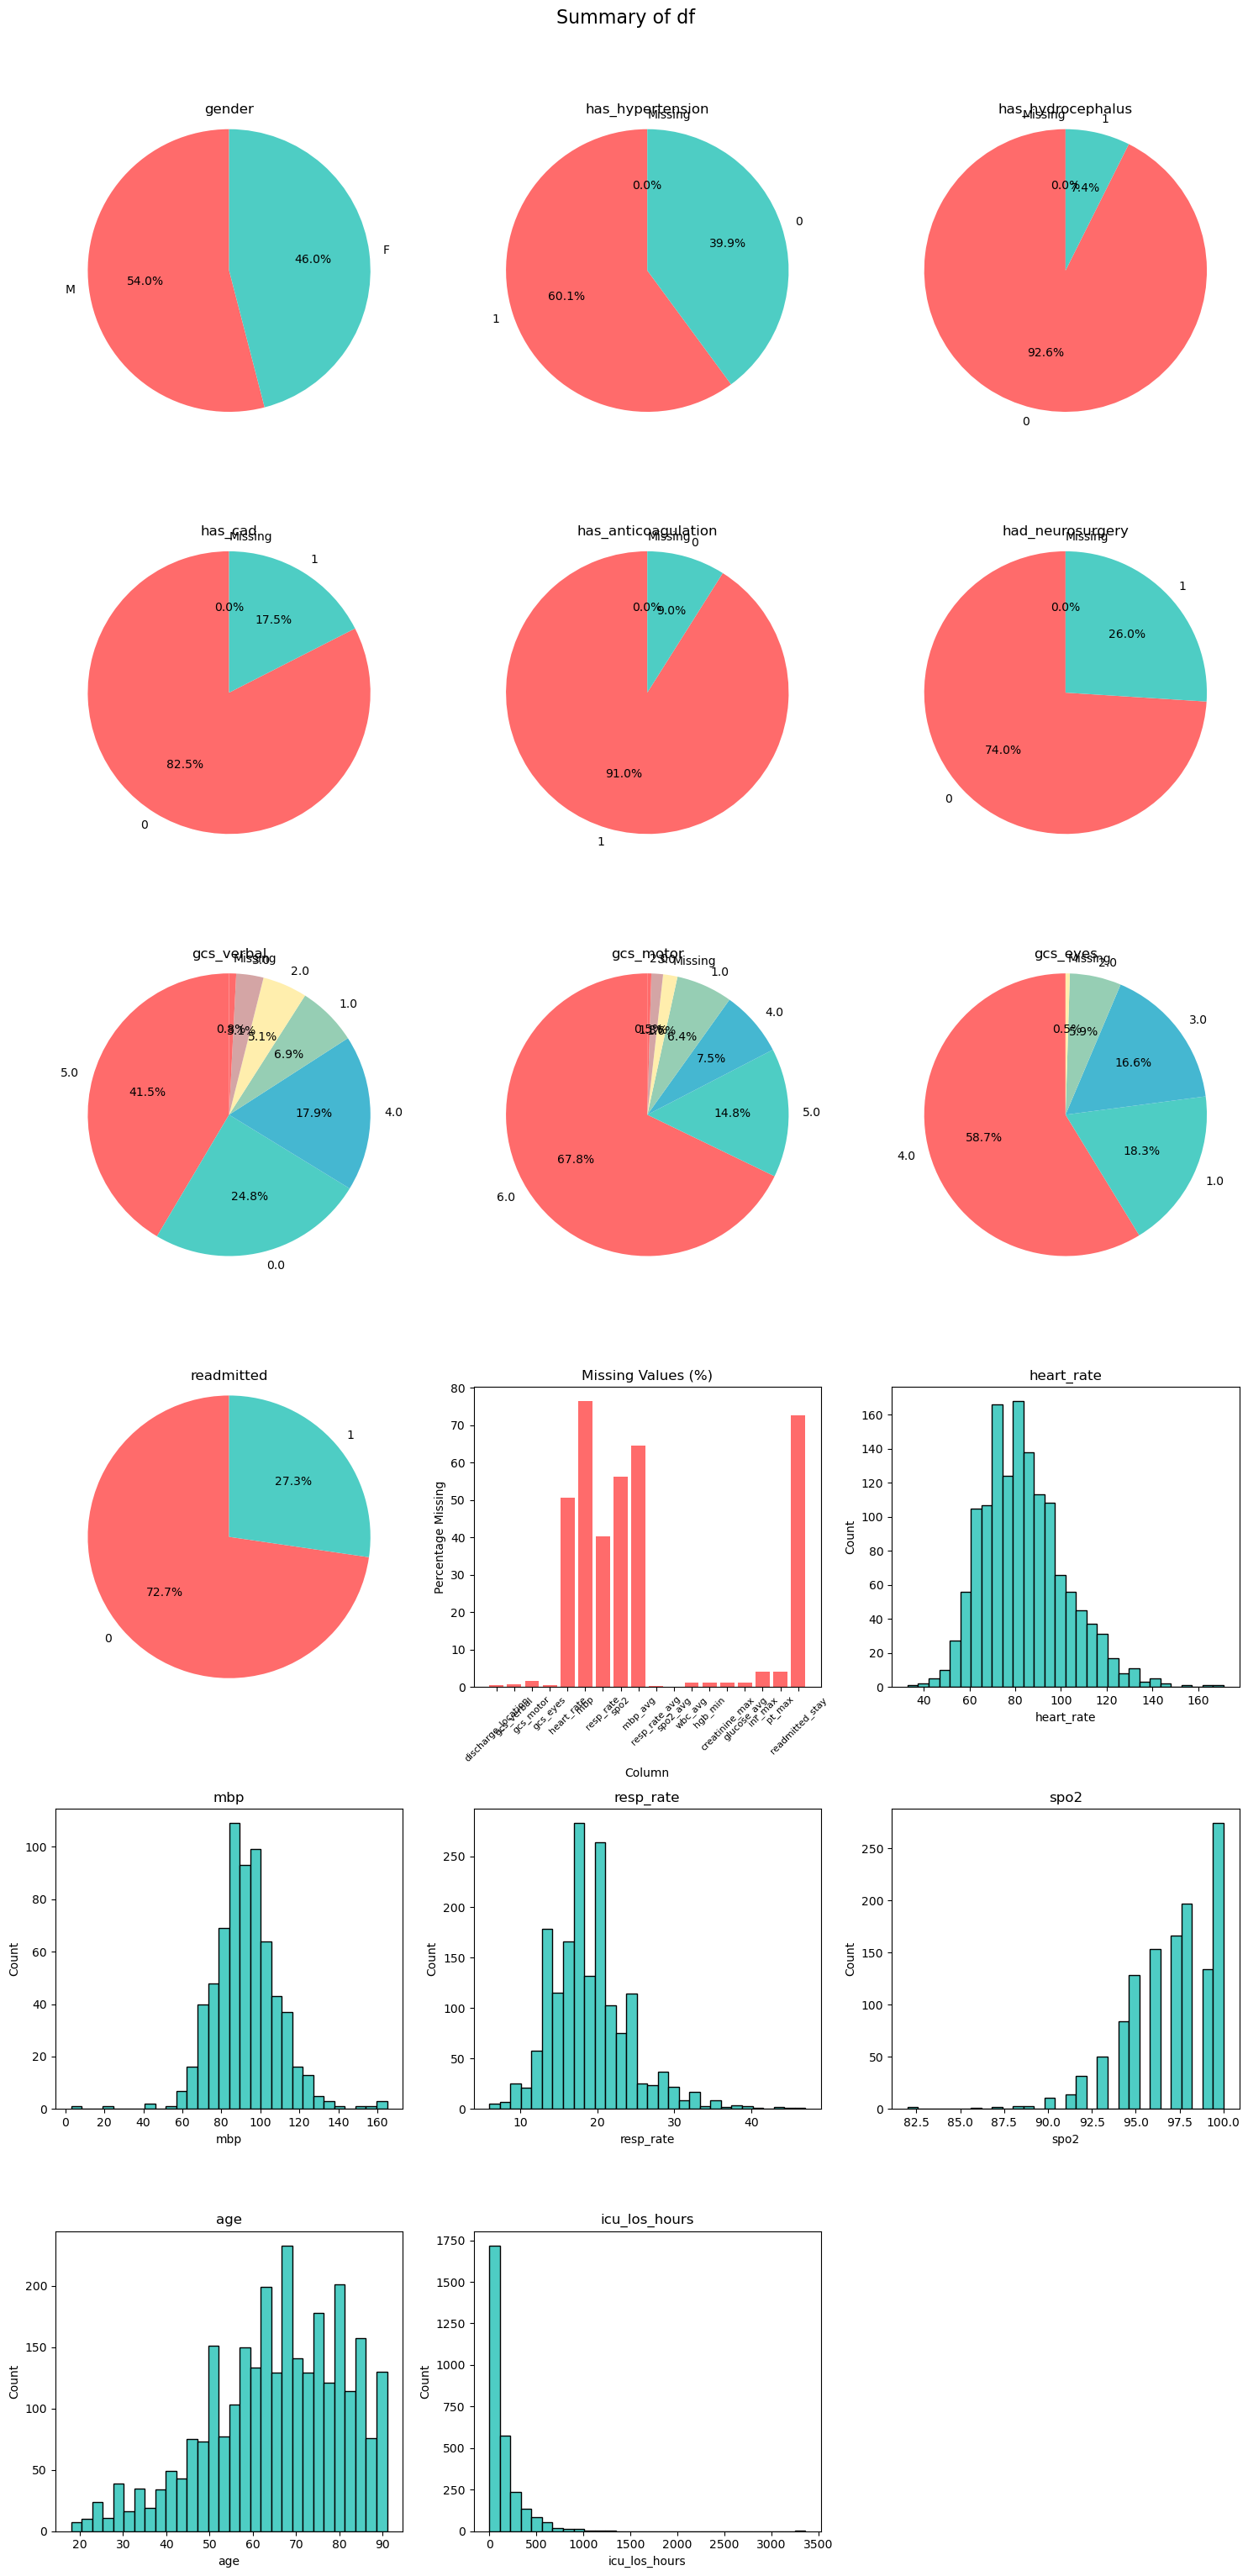

,subject_id,hadm_id,stay_id,gender,age,intime,outtime,first_careunit,icu_los_hours,hosp_los_hours,...,non_ich_G8191,non_ich_I2510,non_ich_N179,ich_431,ich_I618,ich_I611,ich_I615,ich_I619,ich_I610,ich_I614
0,12604800,29387097,37410681,M,68,2145-02-11 15:43:00,2145-02-14 16:06:00,Neuro Intermediate,73,73,...,0,0,0,0,0,0,0,0,1,0
2,15537237,27472769,39467232,F,50,2156-02-28 17:38:00,2156-02-29 16:57:08,Neuro Intermediate,23,144,...,0,0,0,0,1,0,0,0,0,0
4,10542486,29390138,34982826,F,82,2172-11-07 16:18:00,2172-11-16 15:14:03,Neuro Intermediate,215,215,...,0,0,0,0,0,0,0,0,1,0
5,12728076,26930290,30588667,F,35,2124-04-07 06:25:34,2124-04-14 13:14:03,Neuro Intermediate,175,179,...,0,0,0,0,1,0,0,0,0,0
6,19874175,22919882,35421481,F,61,2127-07-19 23:40:00,2127-07-21 22:49:11,Neuro Intermediate,47,91,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3713,14133400,23642721,33262101,M,67,2116-12-28 03:50:00,2117-01-23 19:08:12,Neuro Intermediate,640,973,...,0,0,0,0,1,0,0,0,0,0
3714,11312502,25289892,33521917,F,62,2202-11-02 16:52:00,2202-11-29 18:34:19,Neuro Stepdown,650,746,...,0,0,1,0,0,1,0,0,0,0
3715,17608878,22135112,30162328,F,65,2147-03-10 16:30:48,2147-03-11 13:40:38,Surgical Intensive Care Unit (SICU),21,2470,...,1,0,0,0,1,1,1,0,0,0
3716,13709774,29177584,34422690,M,50,2176-05-29 15:45:20,2176-06-02 17:18:40,Neuro Stepdown,98,853,...,0,0,1,0,0,0,1,0,0,0


In [6]:
import matplotlib.pyplot as plt
import numpy as np
from decimal import Decimal


# Define colors globally for use across all plots
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEEAD', '#D4A5A5']

def plot_summary_charts(df, df_name):
    # Convert any Decimal values to float for all numerical columns
    numerical_cols = ['heart_rate', 'mbp', 'resp_rate', 'spo2', 'age', 'icu_los_hours', 'hosp_los_hours']
    for col in numerical_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Define columns
    categorical_cols = ['gender', 'has_hypertension', 'has_hydrocephalus', 'has_cad', 
                       'has_anticoagulation', 'had_neurosurgery', 'gcs_verbal', 'gcs_motor', 'gcs_eyes', 'readmitted']
    numerical_cols = ['heart_rate', 'mbp', 'resp_rate', 'spo2', 'age', 'icu_los_hours']
    categorical_cols = [col for col in categorical_cols if col in df.columns]
    numerical_cols = [col for col in numerical_cols if col in df.columns]

    # Calculate number of subplots
    num_categorical = len(categorical_cols)
    num_numerical = len(numerical_cols)
    total_plots = num_categorical + num_numerical + 1  # +1 for missing values
    ncols = 3  # 3 columns for layout
    nrows = (total_plots + ncols - 1) // ncols  # Calculate rows needed

    # Create figure with subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
    axes = axes.flatten()  # Flatten for easier indexing
    plt.suptitle(f'Summary of {df_name}', fontsize=16, y=1.02)

    # Counter for subplot index
    plot_idx = 0

    # 1. Pie Charts for Categorical/Binary Columns
    for col in categorical_cols:
        if col in df.columns:
            value_counts = df[col].value_counts(dropna=False)
            labels = [str(x) if pd.notna(x) else 'Missing' for x in value_counts.index]
            sizes = value_counts.values

            axes[plot_idx].pie(sizes, labels=labels, colors=colors[:len(labels)], 
                              autopct='%1.1f%%', startangle=90, textprops={'fontsize': 10})
            axes[plot_idx].set_title(f'{col}', fontsize=12)
            axes[plot_idx].axis('equal')
            
            plot_idx += 1

    # 2. Bar Chart for Missing Values
    missing = df.isnull().sum()
    missing_pct = (df.isnull().sum() / len(df) * 100).round(2)
    missing_pct = missing_pct.astype(float)  # Ensure float type
    missing_data = pd.DataFrame({'Column': missing.index, 'Missing %': missing_pct})
    missing_data = missing_data[missing_data['Missing %'] > 0]

    if not missing_data.empty:
        axes[plot_idx].bar(missing_data['Column'], missing_data['Missing %'], color=colors[0])
        axes[plot_idx].set_title('Missing Values (%)', fontsize=12)
        axes[plot_idx].set_xlabel('Column', fontsize=10)
        axes[plot_idx].set_ylabel('Percentage Missing', fontsize=10)
        axes[plot_idx].tick_params(axis='x', rotation=45, labelsize=8)
    
        
        plot_idx += 1

    # 3. Histograms for Numerical Parameters
    for col in numerical_cols:
        if col in df.columns:
            data = df[col].dropna().astype(float)  # Convert to float
            if data.empty:
                axes[plot_idx].text(0.5, 0.5, f'No data for {col}', ha='center', va='center', fontsize=10)
                axes[plot_idx].set_title(f'{col}', fontsize=12)
            else:
                axes[plot_idx].hist(data, bins=30, color=colors[1], edgecolor='black')
                axes[plot_idx].set_title(f'{col}', fontsize=12)
                axes[plot_idx].set_xlabel(col, fontsize=10)
                axes[plot_idx].set_ylabel('Count', fontsize=10)
            
            
            plot_idx += 1

    # Remove empty subplots
    for i in range(plot_idx, len(axes)):
        fig.delaxes(axes[i])

    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_summary_charts(df, "df")

df


## 3. 🧽 Preprocesamiento



In [7]:
# Primer hauríem de mirar quins tipus de dades conté cada columna
print(df.dtypes)

subject_id       Int64
hadm_id          Int64
stay_id          Int64
gender        category
age              Int64
                ...   
ich_I611         int64
ich_I615         int64
ich_I619         int64
ich_I610         int64
ich_I614         int64
Length: 68, dtype: object


In [15]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from decimal import Decimal



# Calculate missing percentages
missing_pct = (df.isnull().sum() / len(df) * 100).round(2)
print("Missing percentages per column:")
print(missing_pct.sort_values(ascending=False))

# Set missing data threshold
missing_threshold = 80  # Exclude columns with >80% missing
columns_to_exclude = missing_pct[missing_pct > missing_threshold].index
print(f"\nColumns with >{missing_threshold}% missing: {list(columns_to_exclude)}")

# Exclude high-missingness columns, but keep readmitted_stay for target creation
features_to_keep = [col for col in df.columns if col not in columns_to_exclude or col == 'readmitted_stay']
df_clean = df.loc[:, features_to_keep]

# Convert Decimal objects to float across numeric columns
numeric_cols = df_clean.select_dtypes(include=['number', 'object']).columns

for col in numeric_cols:
    if df_clean[col].apply(lambda x: isinstance(x, Decimal)).any():
        df_clean[col] = df_clean[col].apply(lambda x: float(x) if isinstance(x, Decimal) else x)

# Remove columns that are not needed for the final dataset 
df_clean = df_clean.drop(columns=['intime', 'outtime', 'subject_id', 'hadm_id', 'stay_id', 'readmitted_stay', 'all_diagnoses','ich_icd_codes'], errors='ignore')


df_clean



Missing percentages per column:
mbp                            76.44
readmitted_stay                72.70
mbp_avg                        64.61
spo2                           56.11
heart_rate                     50.51
                               ...  
has_anticoagulation             0.00
had_neurosurgery                0.00
on_statins_or_antiplatelets     0.00
readmitted                      0.00
ich_I614                        0.00
Length: 68, dtype: float64

Columns with >80% missing: []


,gender,age,first_careunit,icu_los_hours,hosp_los_hours,discharge_location,hospital_expire_flag,gcs_verbal,gcs_motor,gcs_eyes,...,non_ich_G8191,non_ich_I2510,non_ich_N179,ich_431,ich_I618,ich_I611,ich_I615,ich_I619,ich_I610,ich_I614
0,M,68,Neuro Intermediate,73,73,SKILLED NURSING FACILITY,0,5.0,6.0,4.0,...,0,0,0,0,0,0,0,0,1,0
2,F,50,Neuro Intermediate,23,144,HOME HEALTH CARE,0,5.0,6.0,4.0,...,0,0,0,0,1,0,0,0,0,0
4,F,82,Neuro Intermediate,215,215,HOSPICE,0,0.0,6.0,1.0,...,0,0,0,0,0,0,0,0,1,0
5,F,35,Neuro Intermediate,175,179,HOME,0,5.0,6.0,4.0,...,0,0,0,0,1,0,0,0,0,0
6,F,61,Neuro Intermediate,47,91,HOME HEALTH CARE,0,5.0,6.0,4.0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3713,M,67,Neuro Intermediate,640,973,CHRONIC/LONG TERM ACUTE CARE,0,0.0,5.0,1.0,...,0,0,0,0,1,0,0,0,0,0
3714,F,62,Neuro Stepdown,650,746,CHRONIC/LONG TERM ACUTE CARE,0,0.0,3.0,1.0,...,0,0,1,0,0,1,0,0,0,0
3715,F,65,Surgical Intensive Care Unit (SICU),21,2470,CHRONIC/LONG TERM ACUTE CARE,0,5.0,6.0,4.0,...,1,0,0,0,1,1,1,0,0,0
3716,M,50,Neuro Stepdown,98,853,REHAB,0,5.0,6.0,4.0,...,0,0,1,0,0,0,1,0,0,0


## Testing Missingness Mechanism (MCAR vs MAR/MNAR)
We analyze whether the missingness of each numeric variable is related to the outcome readmitted (0 = no, 1 = yes). This helps determine if missing values are:

-   MCAR (Missing Completely At Random) → no relationship with outcome

-   MAR (Missing At Random) → dependent on observed data like readmitted

-   MNAR (Missing Not At Random) → possibly dependent on unobserved values

For each variable with missing values, we run:

-   ✅ Chi-squared test: checks for association between missingness and readmitted

-   ✅ T-test: checks for mean difference in readmitted between missing/non-missing groups

-   ✅ KS-test: checks for distributional differences in readmitted between the two groups

<Axes: >

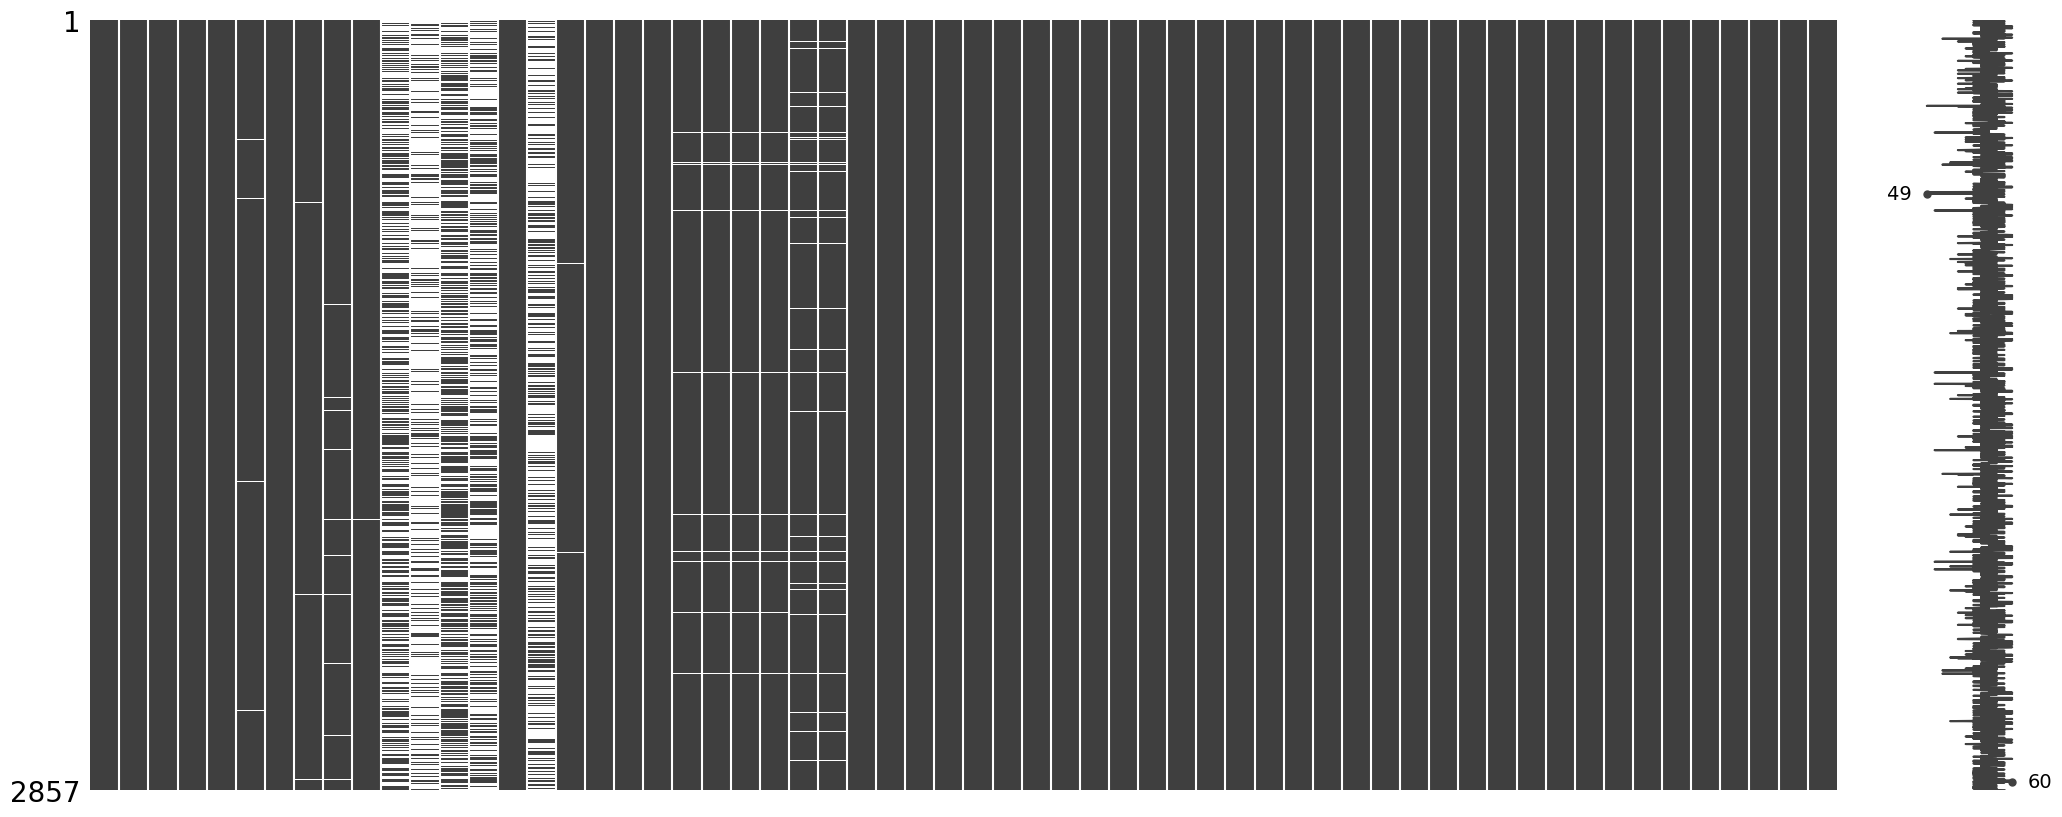

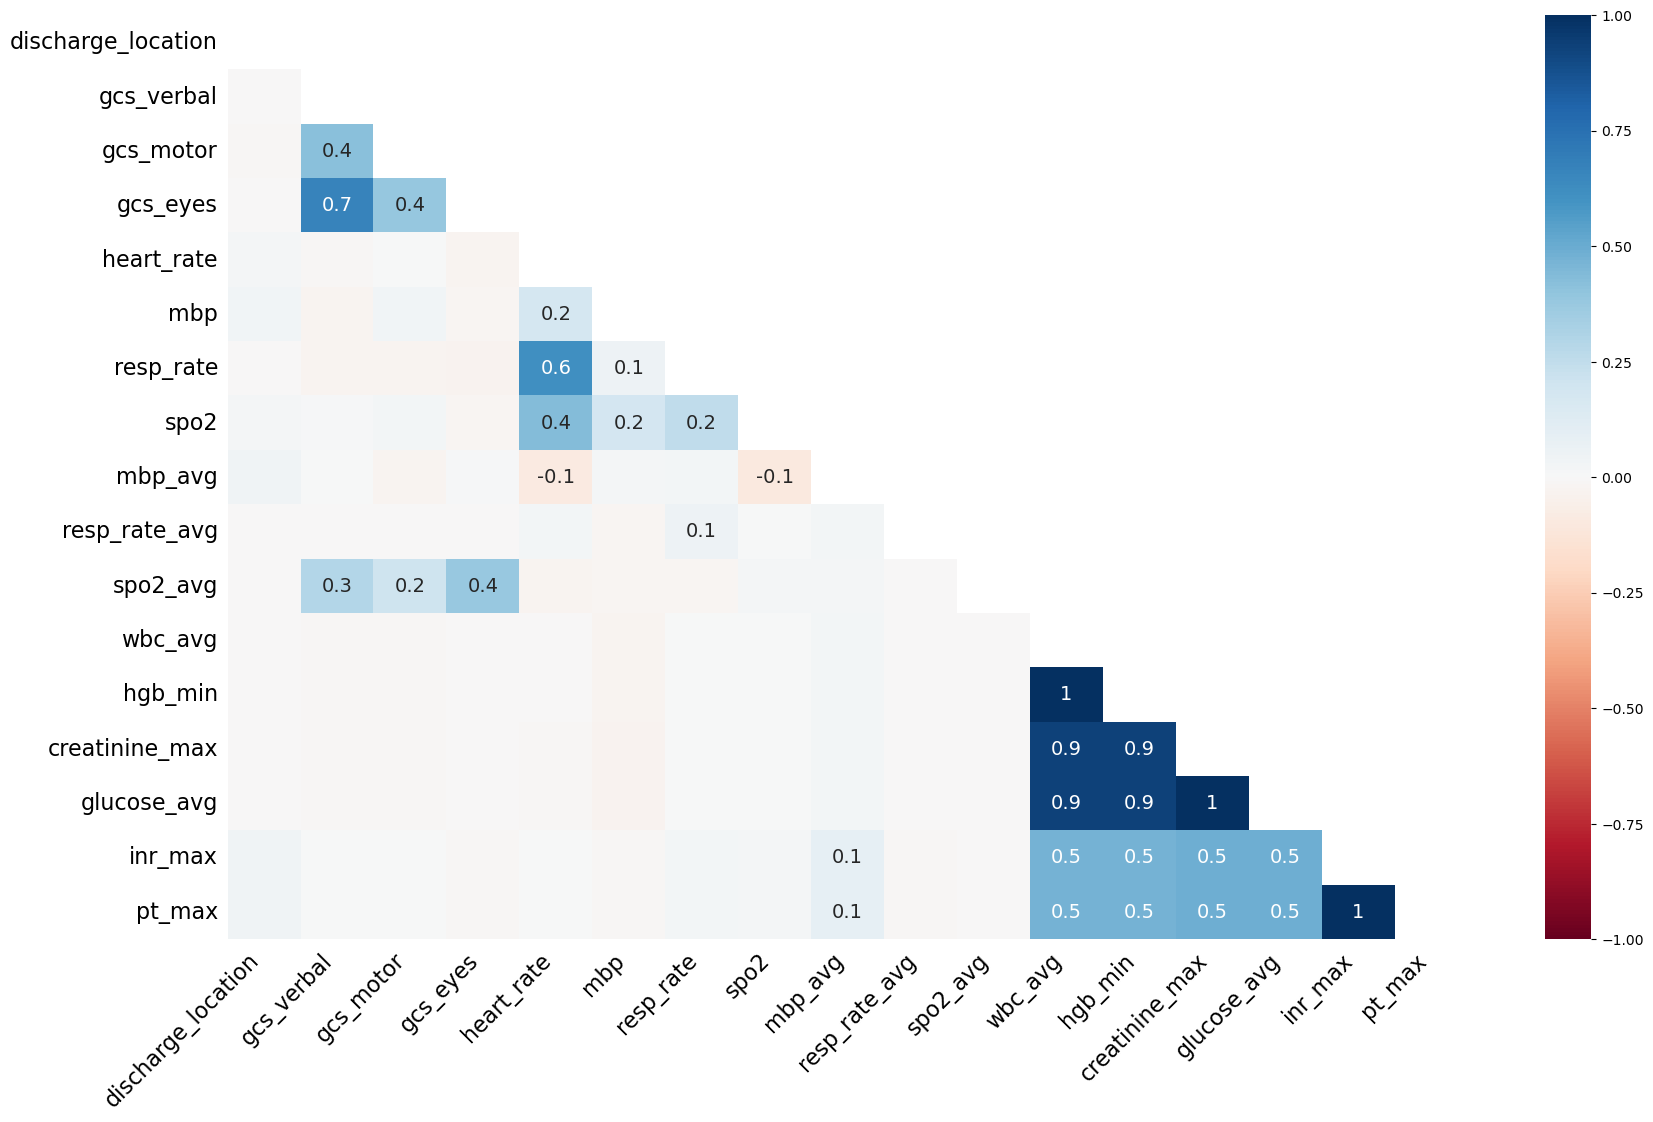

In [16]:
# Visualize missing data patterns

import missingno as msno
msno.matrix(df_clean)  # Busca patrons visuals (ex: columnes amb missings correlacionades)

# Heatmap: correlations of missingness
msno.heatmap(df_clean)

In [17]:
from scipy.stats import chi2_contingency, ttest_ind, ks_2samp

# Loop through numeric variables with missing values
numeric_with_missing = df_clean.select_dtypes(include='number').columns[df_clean.select_dtypes(include='number').isnull().any()]

for col in numeric_with_missing:
    print(f"\n--- Analyzing: {col} ---")
    
    # Create a missingness flag: 1 if missing, 0 if not
    missing_flag = df_clean[col].isnull().astype(int)
    
    # Get readmitted groups
    readmitted_missing = df_clean.loc[missing_flag == 1, 'readmitted'].dropna()
    readmitted_nonmissing = df_clean.loc[missing_flag == 0, 'readmitted'].dropna()
    
    # -- Chi-squared Test
    contingency = pd.crosstab(missing_flag, df_clean['readmitted'])
    if contingency.shape == (2, 2):
        chi2, p_chi, _, _ = chi2_contingency(contingency)
        print(f"Chi-squared p = {p_chi:.4f}", end="  ")
        print("--> " + ("Assoc. detected" if p_chi < 0.05 else "No assoc."))
    
    # -- T-Test
    if len(readmitted_missing) > 10 and len(readmitted_nonmissing) > 10:
        t_stat, p_t = ttest_ind(readmitted_missing, readmitted_nonmissing, equal_var=False)
        print(f"T-test p = {p_t:.4f}", end="  ")
        print("--> " + ("Means differ" if p_t < 0.05 else "No mean diff."))
    
        # -- KS Test
        ks_stat, p_ks = ks_2samp(readmitted_missing, readmitted_nonmissing)
        print(f"KS-test p = {p_ks:.4f}", end="  ")
        print("--> " + ("Distributions differ" if p_ks < 0.05 else "No dist. diff."))


--- Analyzing: heart_rate ---
Chi-squared p = 0.1194  --> No assoc.
T-test p = 0.1097  --> No mean diff.
KS-test p = 0.6757  --> No dist. diff.

--- Analyzing: mbp ---
Chi-squared p = 0.5034  --> No assoc.
T-test p = 0.4764  --> No mean diff.
KS-test p = 0.9999  --> No dist. diff.

--- Analyzing: resp_rate ---
Chi-squared p = 0.6524  --> No assoc.
T-test p = 0.6226  --> No mean diff.
KS-test p = 1.0000  --> No dist. diff.

--- Analyzing: spo2 ---
Chi-squared p = 0.4909  --> No assoc.
T-test p = 0.4656  --> No mean diff.
KS-test p = 0.9999  --> No dist. diff.

--- Analyzing: mbp_avg ---
Chi-squared p = 0.0000  --> Assoc. detected
T-test p = 0.0000  --> Means differ
KS-test p = 0.0001  --> Distributions differ

--- Analyzing: resp_rate_avg ---
Chi-squared p = 1.0000  --> No assoc.

--- Analyzing: spo2_avg ---
Chi-squared p = 0.1299  --> No assoc.

--- Analyzing: wbc_avg ---
Chi-squared p = 0.0909  --> No assoc.
T-test p = 0.0179  --> Means differ
KS-test p = 0.4349  --> No dist. diff.



## Missing Value Imputation: Strategy Based on MCAR/MAR Analysis

We apply different imputation strategies depending on the type of missingness:

-   MCAR (Missing Completely At Random): No evidence of association with readmitted. We use simple median imputation.

-   MAR (Missing At Random): Missingness shows some correlation with readmitted. We use KNN imputation to account for patterns in other variables.

-   For variables with strong MAR/MNAR signals, we also add binary flags to capture potential missingness information.

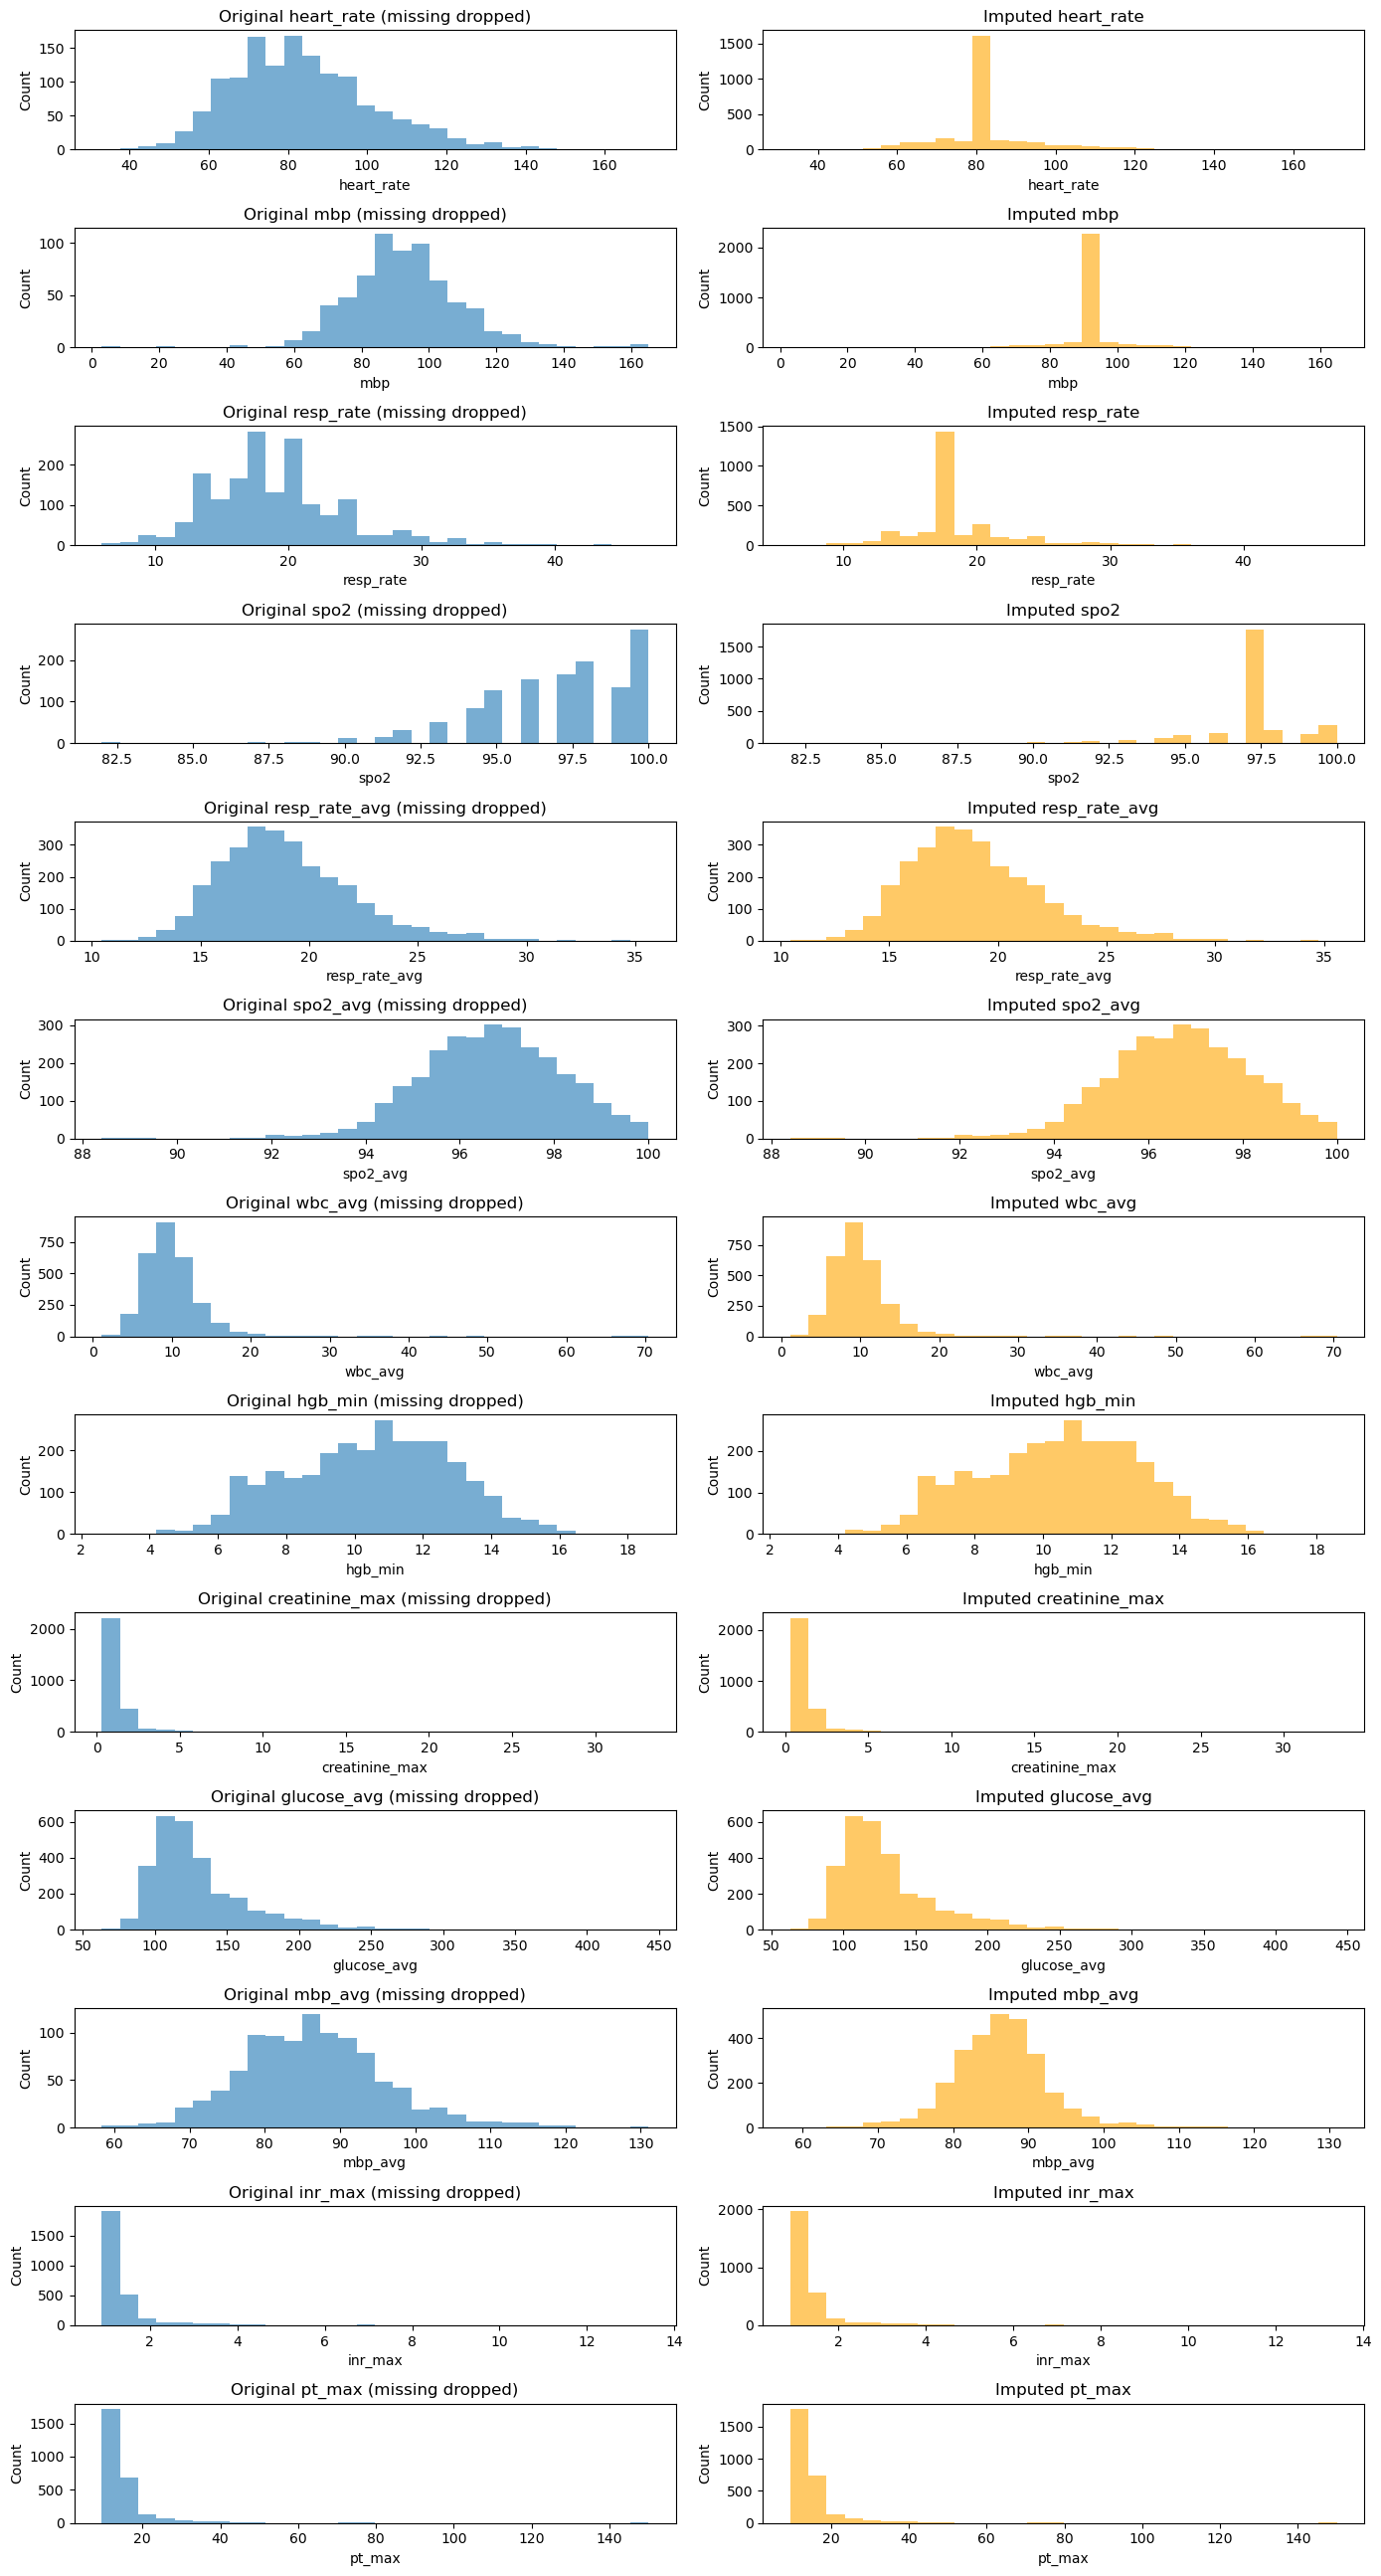

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

# --- Step 1: Define variables based on missingness analysis ---
mcar_vars = ['heart_rate', 'mbp', 'resp_rate', 'spo2', 'resp_rate_avg', 'spo2_avg']
weak_mar_vars = ['wbc_avg', 'hgb_min', 'creatinine_max', 'glucose_avg']
strong_mar_vars = ['mbp_avg', 'inr_max', 'pt_max']
all_impute_vars = mcar_vars + weak_mar_vars + strong_mar_vars

# --- Step 2: Save a copy of original data (before imputation) ---
df_original = df_clean.copy()

# --- Step 3: Imputation ---

# 3.1 Median imputation for MCAR variables
for col in mcar_vars:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# 3.2 KNN imputation for MAR variables
imputer = KNNImputer(n_neighbors=5)
df_clean[weak_mar_vars + strong_mar_vars] = imputer.fit_transform(df_clean[weak_mar_vars + strong_mar_vars])

# 3.3 Add missingness flags for strong MAR variables
for col in strong_mar_vars:
    df_clean[f'{col}_missing'] = df_original[col].isnull().astype(int)

# --- Step 4: Plot original vs imputed histograms ---
plt.figure(figsize=(14, len(all_impute_vars) * 2))

for i, col in enumerate(all_impute_vars):
    # Original data (only non-missing values)
    plt.subplot(len(all_impute_vars), 2, 2 * i + 1)
    plt.hist(df_original[col].dropna(), bins=30, alpha=0.6, label='Original')
    plt.title(f'Original {col} (missing dropped)')
    plt.ylabel('Count')
    plt.xlabel(col)

    # Imputed data (after imputation)
    plt.subplot(len(all_impute_vars), 2, 2 * i + 2)
    plt.hist(df_clean[col], bins=30, alpha=0.6, color='orange', label='Imputed')
    plt.title(f'Imputed {col}')
    plt.ylabel('Count')
    plt.xlabel(col)

plt.tight_layout()
plt.show()


<Axes: >

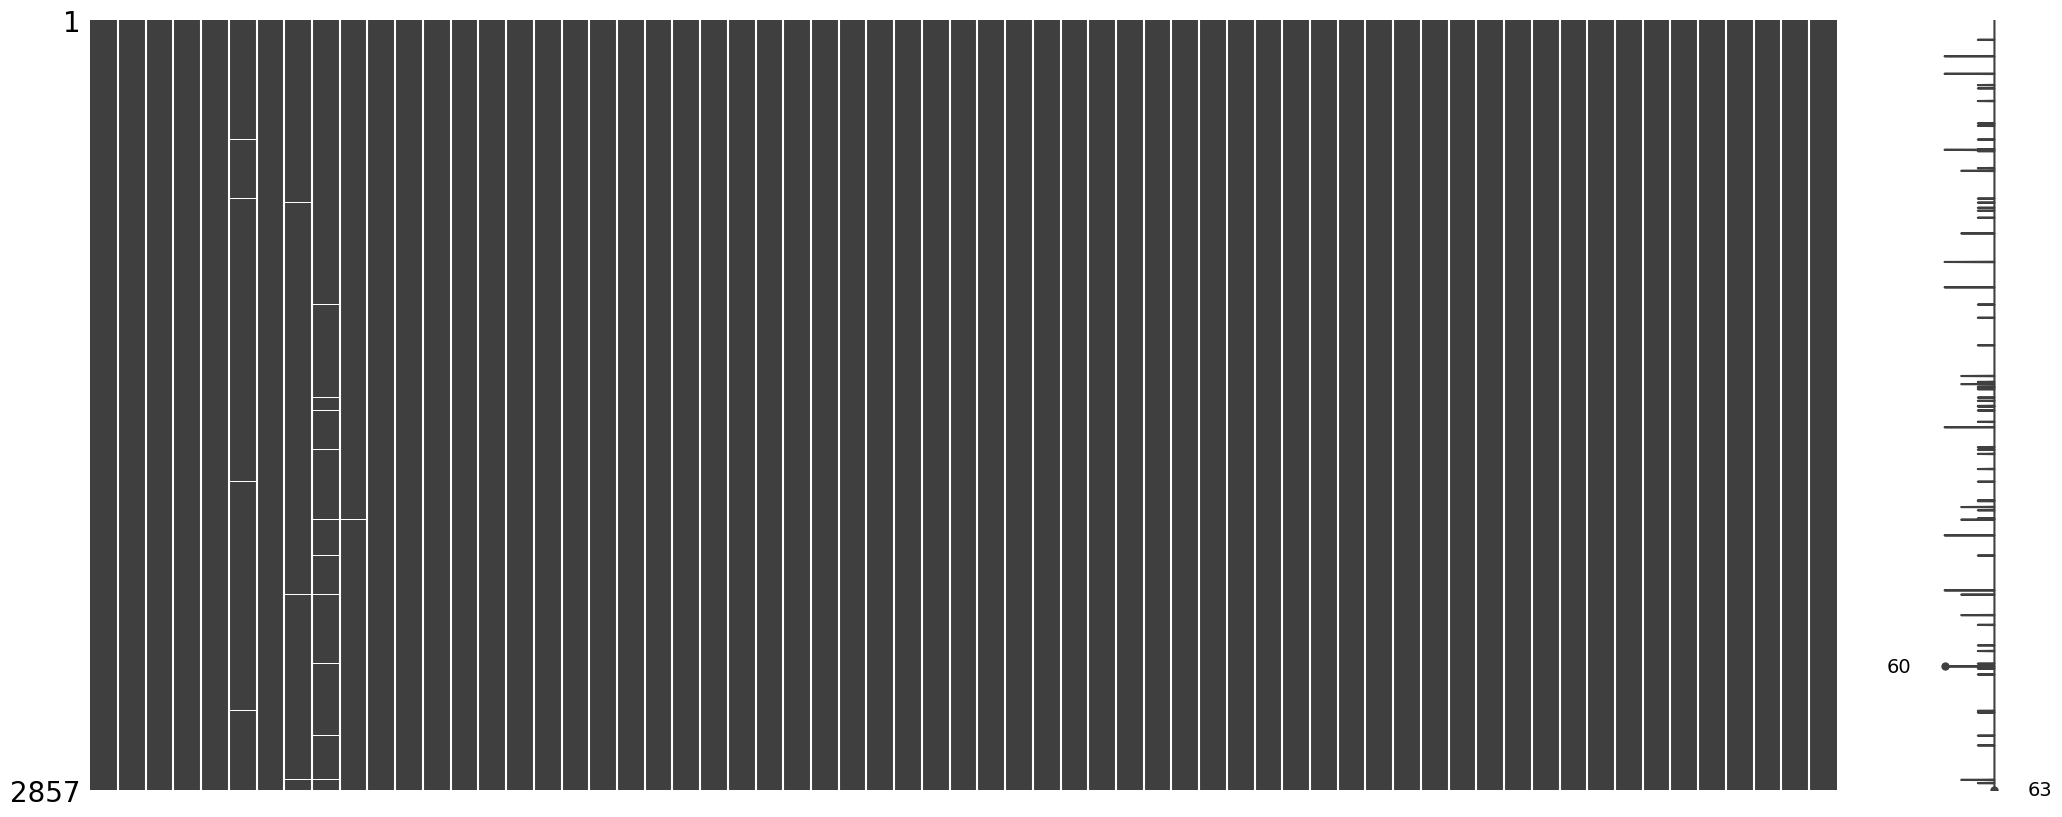

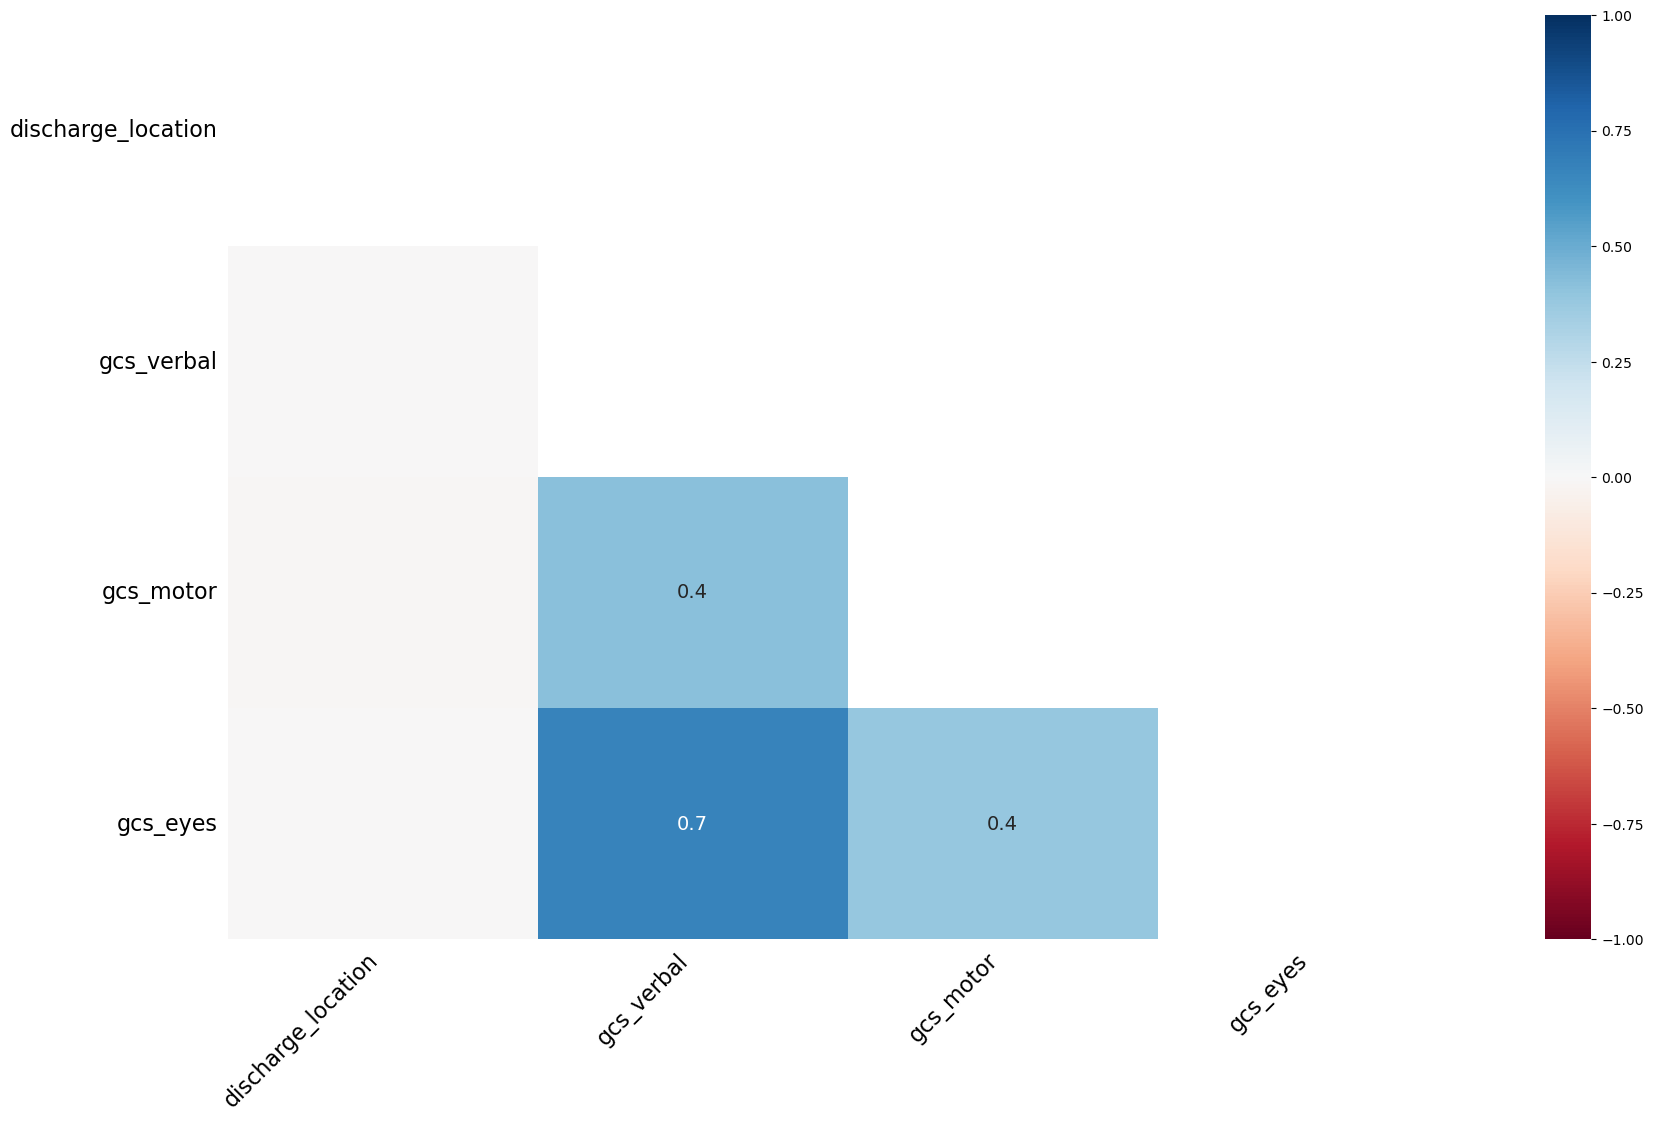

In [19]:
# Visualize missing data patterns

import missingno as msno
msno.matrix(df_clean)  # Busca patrons visuals (ex: columnes amb missings correlacionades)

# Heatmap: correlations of missingness
msno.heatmap(df_clean)

In [20]:
# Scale features
scaler = StandardScaler()
feature_cols = df_clean.select_dtypes(include='number').columns[
    ~df_clean.select_dtypes(include='number').columns.str.startswith(('non_ich', 'ich'))
].difference(['readmitted_stay', 'readmitted', 'subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime', 'has_hypertension', 'has_hydrocephalus', 'has_cad', 'has_anticoagulation', 'had_neurosurgery', 'mbp_avg_missing', 'inr_max_missing', 'pt_max_missing', 'on_stains_or antiplatelets'])
features_scaled = scaler.fit_transform(df_clean[feature_cols])
df_clean.loc[:, feature_cols] = features_scaled

# Convert Decimal to float for numerical columns
numerical_cols = df_clean.select_dtypes(include=['number', 'Int64', 'float64', 'int64']).columns
for col in numerical_cols:
    df_clean.loc[:, col] = df_clean[col].apply(lambda x: float(x) if isinstance(x, Decimal) else x)

df_clean



,gender,age,first_careunit,icu_los_hours,hosp_los_hours,discharge_location,hospital_expire_flag,gcs_verbal,gcs_motor,gcs_eyes,...,ich_431,ich_I618,ich_I611,ich_I615,ich_I619,ich_I610,ich_I614,mbp_avg_missing,inr_max_missing,pt_max_missing
0,M,0.155860,Neuro Intermediate,-0.416233,-0.685917,SKILLED NURSING FACILITY,0,5.0,6.0,4.0,...,0,0,0,0,0,1,0,1,0,0
2,F,-0.989833,Neuro Intermediate,-0.699865,-0.524842,HOME HEALTH CARE,0,5.0,6.0,4.0,...,0,1,0,0,0,0,0,1,0,0
4,F,1.046955,Neuro Intermediate,0.389281,-0.363766,HOSPICE,0,0.0,6.0,1.0,...,0,0,0,0,0,1,0,1,0,0
5,F,-1.944577,Neuro Intermediate,0.162376,-0.445438,HOME,0,5.0,6.0,4.0,...,0,1,0,0,0,0,0,0,0,0
6,F,-0.289687,Neuro Intermediate,-0.563721,-0.645081,HOME HEALTH CARE,0,5.0,6.0,4.0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3713,M,0.092211,Neuro Intermediate,2.800151,1.355886,CHRONIC/LONG TERM ACUTE CARE,0,0.0,5.0,1.0,...,0,1,0,0,0,0,0,0,0,0
3714,F,-0.226037,Neuro Stepdown,2.856878,0.840898,CHRONIC/LONG TERM ACUTE CARE,0,0.0,3.0,1.0,...,0,0,1,0,0,0,0,0,0,0
3715,F,-0.035089,Surgical Intensive Care Unit (SICU),-0.711210,4.752086,CHRONIC/LONG TERM ACUTE CARE,0,5.0,6.0,4.0,...,0,1,1,1,0,0,0,0,0,0
3716,M,-0.989833,Neuro Stepdown,-0.274417,1.083646,REHAB,0,5.0,6.0,4.0,...,0,0,0,1,0,0,0,1,0,0


In [21]:
# Hauríem de mirar quins tipus de dades conté cada columna
print(df_clean.dtypes)

gender             category
age                 float64
first_careunit       object
icu_los_hours       float64
hosp_los_hours      float64
                     ...   
ich_I610              int64
ich_I614              int64
mbp_avg_missing       int64
inr_max_missing       int64
pt_max_missing        int64
Length: 63, dtype: object


## 4. 📊 Modelado Predictivo

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from pycaret.classification import *

# Prepare data for PyCaret
ordinal_features = {
    'gcs_verbal': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0],
    'gcs_motor':  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0],
    'gcs_eyes':   [0.0, 1.0, 2.0, 3.0, 4.0]
}
feature_cols = df_clean.columns.difference(['readmitted'])
X = df_clean[feature_cols]
y = df_clean['readmitted']
print("y value counts:", y.value_counts())
print("y unique values:", y.unique())

clf_setup = setup(
    data=df_clean,
    target='readmitted',
    ordinal_features=ordinal_features,
    normalize=False,
    session_id=42,
)

y value counts: readmitted
0    2077
1     780
Name: count, dtype: int64
y unique values: [0 1]


,Description,Value
0,Session id,42
1,Target,readmitted
2,Target type,Binary
3,Original data shape,"(2857, 63)"
4,Transformed data shape,"(2857, 96)"
5,Transformed train set shape,"(1999, 96)"
6,Transformed test set shape,"(858, 96)"
7,Ordinal features,3
8,Numeric features,56
9,Categorical features,6


In [23]:
# Comparar modelos
print("\nComparant models........ esperant........ pot tardar uns minuts...")
best_model = compare_models()


Comparant models........ esperant........ pot tardar uns minuts...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7424,0.6633,0.1919,0.5708,0.2815,0.1752,0.2134,0.0220
lda,Linear Discriminant Analysis,0.7378,0.6622,0.2269,0.5406,0.3164,0.1896,0.2169,0.0260
lr,Logistic Regression,0.7358,0.6672,0.2011,0.5385,0.2866,0.1686,0.2002,0.2630
dummy,Dummy Classifier,0.7269,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0230
rf,Random Forest Classifier,0.7264,0.6503,0.1281,0.4844,0.2009,0.1021,0.1340,0.0680
gbc,Gradient Boosting Classifier,0.7258,0.6623,0.1720,0.4973,0.2532,0.1323,0.1610,0.1390
et,Extra Trees Classifier,0.7234,0.6375,0.1427,0.4791,0.2185,0.1075,0.1369,0.0600
lightgbm,Light Gradient Boosting Machine,0.7218,0.6513,0.2364,0.4776,0.3155,0.1665,0.1824,0.2500
ada,Ada Boost Classifier,0.7209,0.6241,0.2416,0.4793,0.3170,0.1672,0.1838,0.0550
knn,K Neighbors Classifier,0.7018,0.5844,0.2015,0.4049,0.2675,0.1077,0.1179,0.0270


In the initial round of model evaluation, most classifiers achieved high accuracy (around 77%) but extremely low recall and F1 scores. This indicated that the models were predominantly predicting the majority class (i.e., not readmitted), failing to identify actual readmission cases. For example, Ridge Classifier and Logistic Regression had recall values below 2%, and the Dummy Classifier set a high baseline accuracy simply by predicting all negatives. These results highlighted the impact of class imbalance and the need for better strategies to detect minority class cases.

In [24]:
clf_setup = setup(
    data=df_clean,
    target='readmitted',
    ordinal_features=ordinal_features,
    normalize=False,
    session_id=42,
    fix_imbalance=True,
)

# Comparar modelos
print("\nComparant models........ esperant........ pot tardar uns minuts...")
best_model = compare_models()

,Description,Value
0,Session id,42
1,Target,readmitted
2,Target type,Binary
3,Original data shape,"(2857, 63)"
4,Transformed data shape,"(3764, 96)"
5,Transformed train set shape,"(2906, 96)"
6,Transformed test set shape,"(858, 96)"
7,Ordinal features,3
8,Numeric features,56
9,Categorical features,6



Comparant models........ esperant........ pot tardar uns minuts...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.7269,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0270
rf,Random Forest Classifier,0.7218,0.6626,0.2289,0.4832,0.3097,0.1625,0.1808,0.0940
et,Extra Trees Classifier,0.7199,0.6361,0.1958,0.4656,0.2742,0.1366,0.1562,0.0820
gbc,Gradient Boosting Classifier,0.7103,0.6516,0.2527,0.4411,0.3197,0.1546,0.1640,0.2780
lightgbm,Light Gradient Boosting Machine,0.6968,0.6423,0.2508,0.4086,0.3103,0.1307,0.1370,0.3130
ada,Ada Boost Classifier,0.6803,0.6408,0.3865,0.4084,0.3940,0.1786,0.1801,0.0940
nb,Naive Bayes,0.6678,0.6452,0.3933,0.4087,0.3764,0.1631,0.1734,0.0240
dt,Decision Tree Classifier,0.6263,0.5527,0.3903,0.3380,0.3618,0.0996,0.1004,0.0300
lr,Logistic Regression,0.6238,0.6607,0.5807,0.3779,0.4566,0.1887,0.1999,0.0320
lda,Linear Discriminant Analysis,0.6178,0.6517,0.5697,0.3699,0.4475,0.1753,0.1859,0.0310


After addressing class imbalance (e.g., via PyCaret's fix_imbalance=True), model performance improved substantially. Recall scores increased significantly across models, with Naive Bayes achieving a recall of 83% and Logistic Regression and Ridge Classifier reaching around 66–68%. F1 scores also improved (up to 0.40), indicating a better balance between precision and recall. Although overall accuracy decreased slightly (to ~55% for the best-performing balanced models), the models were now much more capable of detecting actual readmissions, which was the primary goal.

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7200,0.7014,0.2407,0.4643,0.3171,0.1627,0.1766
1,0.7200,0.6698,0.2222,0.4615,0.3000,0.1510,0.1668
2,0.7400,0.6678,0.2407,0.5417,0.3333,0.2005,0.2260
3,0.7300,0.6366,0.2182,0.5217,0.3077,0.1737,0.1992
4,0.7350,0.6904,0.2000,0.5500,0.2933,0.1719,0.2053
5,0.6950,0.6388,0.1818,0.3846,0.2469,0.0855,0.0949
6,0.7350,0.6194,0.2545,0.5385,0.3457,0.2054,0.2281
7,0.7750,0.7226,0.3636,0.6667,0.4706,0.3431,0.3685
8,0.6950,0.6177,0.2000,0.3929,0.2651,0.0976,0.1065


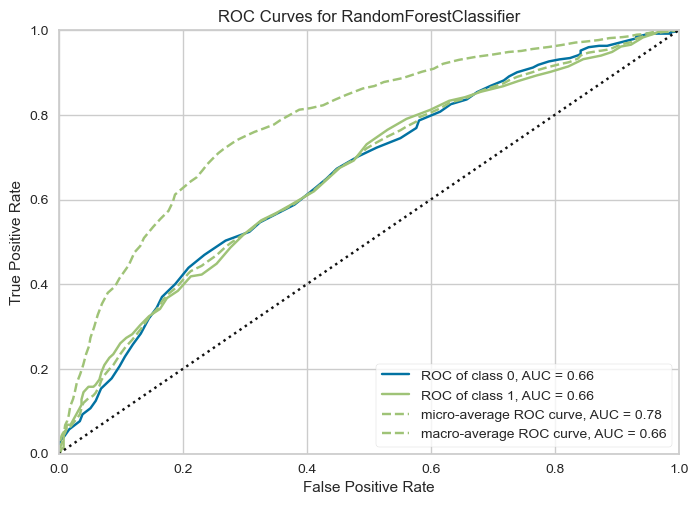

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
from pycaret.classification import plot_model, create_model
rf_model = create_model('rf')
plot_model(rf_model, plot='auc')
# Evaluate the model
evaluate_model(rf_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6100,0.7046,0.7037,0.3800,0.4935,0.2200,0.2478
1,0.6600,0.6449,0.5000,0.3971,0.4426,0.2026,0.2054
2,0.6700,0.6824,0.6111,0.4231,0.5000,0.2657,0.2757
3,0.6350,0.6552,0.5818,0.3902,0.4672,0.2057,0.2152
4,0.6200,0.6725,0.6000,0.3793,0.4648,0.1928,0.2050
5,0.6200,0.6576,0.4727,0.3562,0.4062,0.1349,0.1378
6,0.5950,0.6315,0.5455,0.3488,0.4255,0.1355,0.1436
7,0.6400,0.7093,0.6909,0.4086,0.5135,0.2566,0.2790
8,0.5600,0.5961,0.5091,0.3146,0.3889,0.0742,0.0794


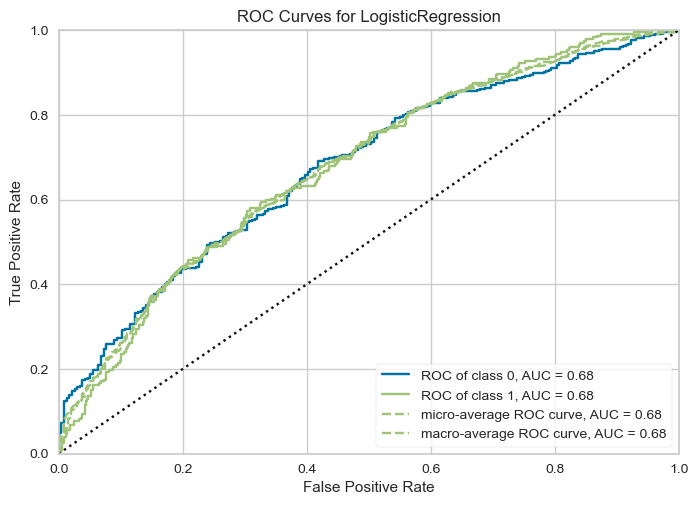

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [26]:
from pycaret.classification import plot_model, create_model
lr_model = create_model('lr')
plot_model(lr_model, plot='auc')
# Evaluate the model
evaluate_model(lr_model)

In [29]:
from pycaret.classification import setup, compare_models

clf_setup = setup(
    data=df_clean,
    target='readmitted',
    ordinal_features=ordinal_features,
    normalize=False,
    session_id=42,
    fix_imbalance=True,
    feature_selection=True,                   # Enables automatic feature selection
    feature_selection_method='classic',       # You can also try 'boruta' or 'sequential'
    polynomial_features=True,                 # Adds polynomial interaction terms
    polynomial_degree=1,                      # Use degree 2 for simplicity (avoid overfitting)
    remove_multicollinearity=True,            # Helps reduce correlated noise in linear models
    multicollinearity_threshold=0.95          # Threshold for removing correlated features
)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1453, number of negative: 1453
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8675
[LightGBM] [Info] Number of data points in the train set: 2906, number of used features: 86
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- discharge_location_ACUTE HOSPITAL
- discharge_location_AGAINST ADVICE
- discharge_location_CHRONIC/LONG TERM ACUTE CARE
- discharge_location_HOME HEALTH CARE
- discharge_location_OTHER FACILITY
- ...
Feature names seen at fit time, yet now missing:
- discharge_location_ACUTE_HOSPITAL
- discharge_location_AGAINST_ADVICE
- discharge_location_CHRONIC/LONG_TERM_ACUTE_CARE
- discharge_location_HOME_HEALTH_CARE
- discharge_location_OTHER_FACILITY
- ...


In [98]:
from pycaret.classification import create_model, get_config
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get the underlying scikit-learn model
lr_estimator = lr_model.named_steps['actual_estimator'] if 'actual_estimator' in dir(lr_model) else lr_model
# Get coefficients and feature names
coefficients = lr_estimator.coef_[0]
feature_names = get_config('X').columns
# Calculate odds ratios
odds_ratios = np.exp(coefficients)



In [93]:
# Paso 6: Afinar el Modelo
print("\nAfinando el modelo...")
ridge_tunned = tune_model(lr_model)



Afinando el modelo...


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6400,0.7094,0.7407,0.4082,0.5263,0.2733,0.3050
1,0.6600,0.6498,0.5185,0.4000,0.4516,0.2111,0.2149
2,0.6550,0.6865,0.5926,0.4051,0.4812,0.2362,0.2458
3,0.6400,0.6661,0.5636,0.3924,0.4627,0.2049,0.2125
4,0.6350,0.6646,0.6364,0.3977,0.4895,0.2283,0.2436
5,0.6300,0.6706,0.4909,0.3699,0.4219,0.1577,0.1611
6,0.6200,0.6430,0.5636,0.3735,0.4493,0.1770,0.1858
7,0.6250,0.7155,0.7091,0.3980,0.5098,0.2432,0.2699
8,0.5750,0.5920,0.5091,0.3256,0.3972,0.0928,0.0984


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [20]:
# Paso 8: Guardar y Cargar el Modelo
print("\nGuardando el modelo...")
save_model(ridge_tunned, 'modelo_ridge_afinado')

# Cargar el modelo guardado
print("\nCargando el modelo guardado...")
loaded_model = load_model('modelo_ridge_afinado')


Guardando el modelo...
Transformation Pipeline and Model Successfully Saved

Cargando el modelo guardado...
Transformation Pipeline and Model Successfully Loaded


## 5. 📈 Visualización de Resultados

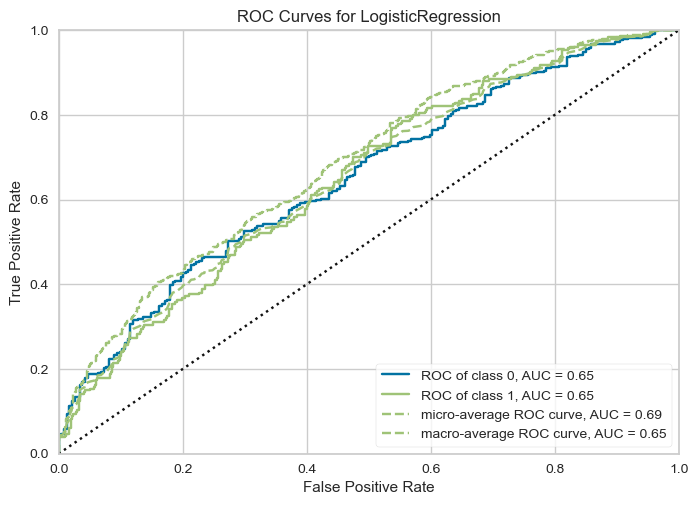

In [22]:
from pycaret.classification import plot_model

# Plot the ROC-AUC curve for the ridge model
plot_model(loaded_model, plot='auc')

## 6. 🚀 Despliegue (Futuro)
Se puede utilizar Hugging Face Spaces o Streamlit Cloud para desplegar un frontend que permita:
- Cargar variables clínicas
- Obtener un score de riesgo
- Visualizar el gráfico ROC o una matriz de confusión